In [1]:
# Copyright (c) 2019 ETH Zurich, Lukas Cavigelli, Georg Rutishauser, Luca Benini

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec
plt.rc('axes', axisbelow=True)
import pandas as pd

from reporting import readTable, parseTable

In [4]:
# provide the list of result files to analyze: 
fnames = [
         'results/results-190727-015659.pkl', 
         'results/results-190727-045529.pkl', 
         'results/results-190727-064751.pkl', 
         'results/results-190727-132915.pkl', 
         'results/results-190727-182855.pkl', 
         ]
dfs = [pd.read_pickle(fname) for fname in fnames]
df = pd.concat(dfs, axis=0, join='outer', ignore_index=False)

(1, 16.0803901757793)

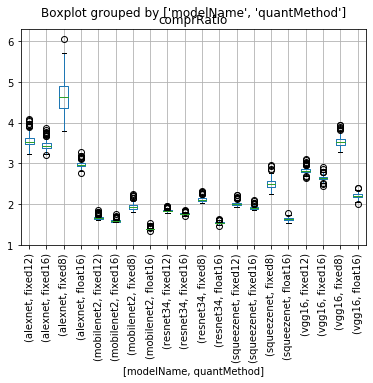

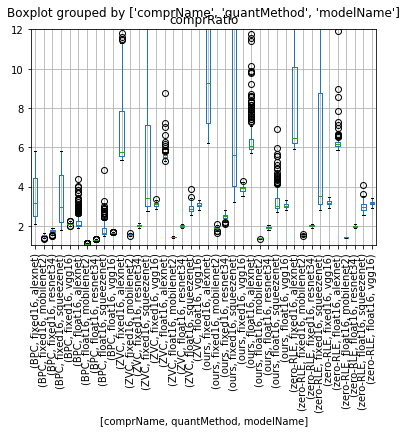

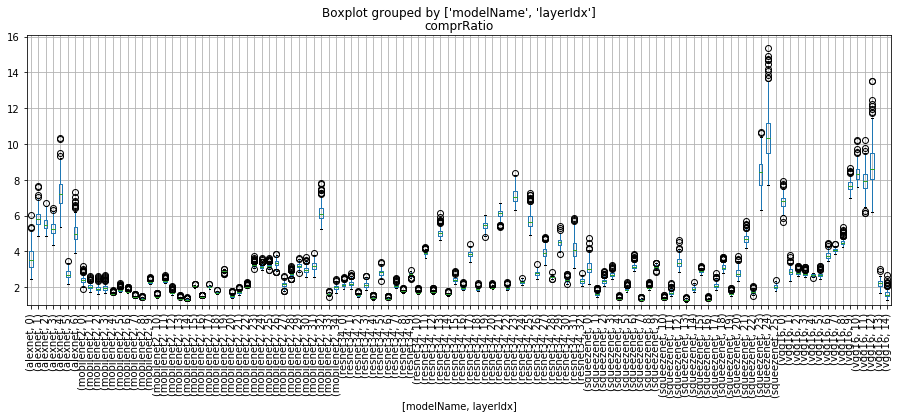

In [5]:
df2 = df.loc[(df['dataDescr'] == 'outputs') & (df['comprName'] == 'ours')]
totalOverLayers = df2.groupby(['modelName','quantMethod','intraBatchIdx']).agg({'comprSize': 'sum', 'comprSizeBaseline': 'sum'})
totalOverLayers.insert(2, 'comprRatio', totalOverLayers.comprSizeBaseline/totalOverLayers.comprSize)
totalOverLayers.boxplot(column='comprRatio', by=['modelName', 'quantMethod'], rot=90)
plt.ylim(bottom=1)

df2 = df.loc[(df['dataDescr'] == 'gradients')]
totalOverLayers = df2.groupby(['quantMethod', 'modelName','comprName','intraBatchIdx']).agg({'comprSize': 'sum', 'comprSizeBaseline': 'sum'})
totalOverLayers.insert(2, 'comprRatio', totalOverLayers.comprSizeBaseline/totalOverLayers.comprSize)
totalOverLayers.boxplot(column='comprRatio', by=['comprName', 'quantMethod', 'modelName'], rot=90)
plt.ylim(bottom=1, top=12)

#by layer analysis
df2 = df.loc[(df['comprName'] == 'ours') & 
             (df['dataDescr'] == 'outputs') & 
             (df['quantMethod'] == 'fixed8')]
totalOverLayers = df2.groupby(['layerIdx', 'modelName', 'intraBatchIdx']).agg({'comprSize': 'sum', 'comprSizeBaseline': 'sum'})
totalOverLayers.insert(2, 'comprRatio', totalOverLayers.comprSizeBaseline/totalOverLayers.comprSize)
totalOverLayers.boxplot(column='comprRatio', by=['modelName', 'layerIdx'], rot=90, figsize=(15,5))
plt.ylim(bottom=1)

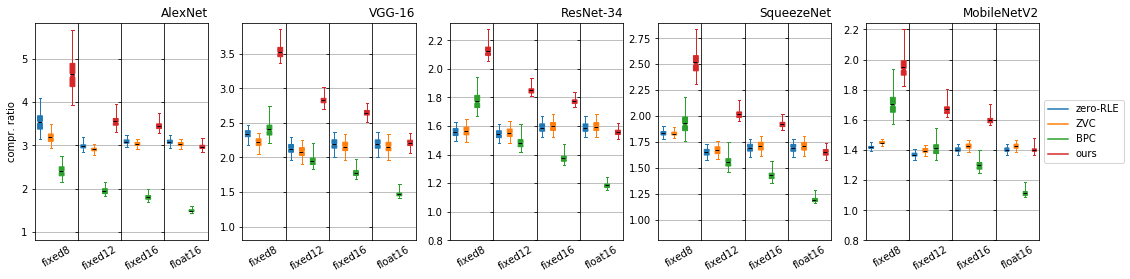

In [6]:
df1 = df.loc[df['dataDescr'] == 'outputs']
# df1 = df.loc[df['dataDescr'] == 'gradients']


# modelNames = df1['modelName'].unique()
# modelNames = dict(zip(modelNames, modelNames))
modelNames = {'alexnet': 'AlexNet', 
              'vgg16': 'VGG-16', 
              'resnet34': 'ResNet-34', 
              'squeezenet': 'SqueezeNet', 
              'mobilenet2': 'MobileNetV2'
             }
quantMethods = df1['quantMethod'].unique()
comprNames = ['zero-RLE', 'ZVC', 'BPC', 'ours']

new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

fig = plt.figure(figsize=(18,4))
gridOuter = matplotlib.gridspec.GridSpec(nrows=1, ncols=len(modelNames), wspace=0.2, hspace=0.2)

for io, (go, modelName) in enumerate(zip(gridOuter, modelNames.keys())):
    gridInner = matplotlib.gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=len(quantMethods),
                                                 subplot_spec=go, wspace=0.0, hspace=0.0)
    
    df2 = df1.loc[df1['modelName'] == modelName]
    for ii, (gi, quantMethod) in enumerate(zip(gridInner, quantMethods)):
        df3 = df2.loc[df2['quantMethod'] == quantMethod]
        
        
        df4 = df3.groupby(['comprName', 'intraBatchIdx']).agg({'comprSize': 'sum', 'comprSizeBaseline': 'sum'})
        df4.insert(2, 'comprRatio', df4.comprSizeBaseline/df4.comprSize)
        df4 = df4.reset_index()

        if ii == 0:
            ax = fig.add_subplot(gi)
            axmain = ax
        else:
            ax = fig.add_subplot(gi, sharey=axmain)
        plt.sca(ax)
        df4.loc[df4['comprSize'] == 0] = 1
        data = [df4.loc[(df4['comprName'] == comprName)]['comprRatio'].tolist() for comprName in comprNames]
        bp = plt.boxplot(data,#df3.groupby('comprName')['comprRatio'].apply(list).tolist(), 
                         notch=True, patch_artist=True, showfliers=False, 
                         showmeans=True, meanline=True, whis=[1,99])#5,95])
        
        def setBoxColors(bp, idx, color):
            bp['boxes'][idx].set(color=color)
            bp['caps'][2*idx].set(color=color)
            bp['caps'][2*idx+1].set(color=color)
            bp['whiskers'][2*idx].set(color=color)
            bp['whiskers'][2*idx+1].set(color=color)
            bp['medians'][idx].set(color=color)
            bp['means'][idx].set(color='black')
        for idx, color in zip(range(len(bp['boxes'])), new_colors):
            setBoxColors(bp, idx, color)
            
        plt.grid(axis='y')
        plt.xlabel(quantMethod, rotation=30)
        plt.ylim(bottom=0.8)
        bottom, top = plt.ylim()
        if top > 20:
            plt.ylim(top=20)
        
        ax.tick_params(axis='x', labelbottom=False, length=0)
        if ii > 0:
            ax.tick_params(axis='y', labelleft=False)
        
        
        if (ii == 0) & (io == 0):
            plt.ylabel('compr. ratio')
        if ii == len(quantMethods)-1:
            plt.title(modelNames[modelName], loc='right')
        if (io == len(modelNames)-1) & (ii == len(quantMethods)-1):
            hs = [plt.plot([1,1], color)[0] for color, _ in zip(new_colors, comprNames)]
            plt.legend(hs, comprNames, loc='center left', bbox_to_anchor=(1, 0.5))
            for h in hs: 
                h.set_visible(False)
            
plt.savefig('figs/totalComprRate-v2.pdf', bbox_inches='tight', pad_inches=0.0)

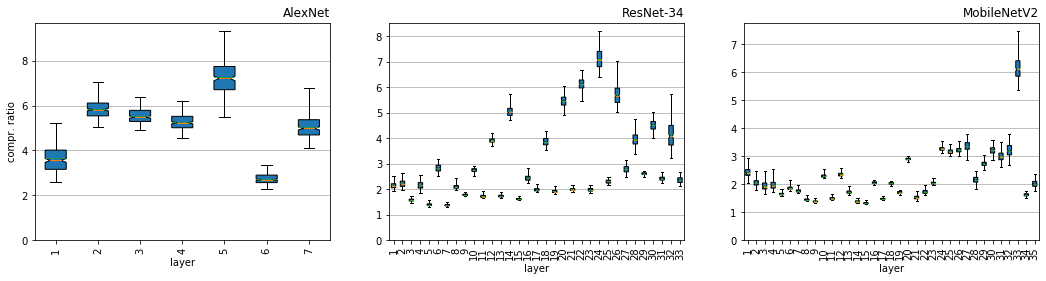

In [7]:
df1 = df.loc[(df['dataDescr'] == 'outputs') & (df['quantMethod'] == 'fixed8') & (df['comprName'] == 'ours')]
# df1 = df.loc[df['dataDescr'] == 'gradients']


# modelNames = df1['modelName'].unique()
# modelNames = dict(zip(modelNames, modelNames))
modelNames = {'alexnet': 'AlexNet', 
              'resnet34': 'ResNet-34', 
              'mobilenet2': 'MobileNetV2', 
#               'mobilenetV2-cust': 'mobilenetV2-cust'
             }
quantMethods = df1['quantMethod'].unique()
comprNames = ['zero-RLE', 'ZVC', 'BPC', 'ours']#df['comprName'].unique()

new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

fig, axarr = plt.subplots(nrows=1, ncols=len(modelNames), 
                          sharey=False, figsize=(18,4), 
#                           gridspec_kw={'width_ratios':[1,3,3]}, # only for final plot
                          squeeze=True)

for ii, (ax, modelName) in enumerate(zip(axarr, modelNames.keys())):
    df2 = df1.loc[df1['modelName'] == modelName]
    
    plt.sca(ax)
    numLayers = df2['layerIdx'].max()+1
    layerIdxs = list(range(numLayers))


    data = [df2.loc[(df2['layerIdx'] == layerIdx)]['comprRatio'].tolist() for layerIdx in layerIdxs]
    bp = plt.boxplot(data,
                     notch=True, patch_artist=True, showfliers=False, 
                     showmeans=True, meanline=True, whis=[1,99])#5,95])

    plt.grid(axis='y')
    plt.xlabel('layer')
    plt.xticks([i+1 for i in layerIdxs], rotation=90)
    plt.ylim(bottom=0)
    if top > 10:
        plt.ylim(bottom=0, top=10)

    if ii == 0:
        plt.ylabel('compr. ratio')
    plt.title(modelNames[modelName], loc='right')
            
plt.savefig('figs/perLayerComprRate-v2.pdf', bbox_inches='tight', pad_inches=0.0)